# Bayesian Logistic Regression with Feature Engineering for Red Wine Quality Data Set

We perform logistic regression with feature engineering and mean-zero Gaussian prior for the 11-dimensional *red wine quality data set*, as can be retrieved from [Kaggle](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009), normalized so that each feature has sample mean zero and sample variance one. Specifically, we append all two-way interactions between given features to the data. That is, we replace every feature vector $v = (v_1,...v_{d_{\text{raw}}})^T$ in the original data by its augmented version

$$ 
(v_1,...,v_{d_{\text{raw}}}, v_1^2, v_1 v_2, v_2^2, ... , v_{d_{\text{raw}}-1} v_{d_{\text{raw}}}, v_{d_{\text{raw}}}^2, 1 ) \in \mathbb{R}^d ,
$$

so that we end up with $d = 78$.

Denote the augmented data set as $(a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}} \subset \mathbb{R}^d \times \{-1,1\}$, where $n_{\text{data}} = 1599$.
Our prior is the mean-zero Gaussian $\mathcal{N}_d(0, \sigma^2 I_d)$ with $\sigma^2 = 100$. The likelihood is obtained by the usual logistic regression model. Our target density, the (unnormalized) posterior density, is therefore given by
$$
\varrho(x)
= \mathcal{N}_d(x; 0, \sigma^2 I_d) \prod_{i=1}^{n_{\text{data}}} \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} , 
\quad x \in \mathbb{R}^d .
$$

**Note:** With the current setting, the experiment requires quite a lot of memory ($> 16$ GB).

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
import stan_utils as su
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import time as tm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/BLR-FE_wine_quality_"

### Retrieve and Prepare the Data, do Feature Engineering, Construct the Target Density

In [4]:
# load data set from file
data = pd.read_csv("../data/red_wine_quality.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
# retrieve features , do feature engineering
raw_feats = data.drop('quality', axis=1)
n_data = raw_feats.shape[0]
d_raw = raw_feats.shape[1]
# normalize features to mean zero and unit variance
medium_feats = ((raw_feats - raw_feats.mean()) / raw_feats.std()).to_numpy()
# do feature engineering (original data, two-way interactions, constant for intercept)
d = d_raw + (d_raw * (d_raw + 1) // 2) + 1
well_done_feats = np.zeros((n_data, d))
well_done_feats[:,:d_raw] = medium_feats
col = d_raw
for i in range(d_raw):
    for j in range(i+1):
        well_done_feats[:,col] = medium_feats[:,i] * medium_feats[:,j]
        col += 1
well_done_feats[:,col] = np.ones(n_data)
# use the resulting features for logistic regression
a = well_done_feats

In [6]:
# assign binary labels ("quality >= 6" -> +1, "quality < 6" -> -1)
labels = data['quality'].to_numpy()
b = np.array(labels >= 6, dtype=int) - np.array(labels < 6, dtype=int)

In [7]:
_, cnts = np.unique(b, return_counts=True)
print("There are {} wine samples of quality < 6 and {} wine samples of quality >= 6.".format(cnts[0],cnts[1]))

There are 744 wine samples of quality < 6 and 855 wine samples of quality >= 6.


In [8]:
# set/retrieve some general parameters
d = a.shape[1]
print("Sample space dimension: d = {}".format(d))
sig_sq = 100 # prior variance

Sample space dimension: d = 78


In [9]:
# construct posterior
def log_density(x):
    return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))

#### Special Treatment for Stan

In [10]:
stan_code = su.BLR_CODE
stan_data = su.blr_data(n_data, d, a, b, np.sqrt(sig_sq))

In [11]:
su.prevent_crashes(stan_code, stan_data)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (1/1)
Sampling: 100% (1/1), done.
Messages received during sampling:
  Gradient evaluation took 8.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


### Run the Samplers

In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If PATT-GPSS is run before HRUSS and AdaRWM, it can break the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [12]:
n_chains = 10 # number of parallel chains permitted to each sampler
n_its = int(1e5) # total number of iterations per chain, per sampler (except AdaRWM)
x_0s = rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-Run Uniform Slice Sampling

In [13]:
w_hruss = 1.0

In [14]:
samples_hruss, tde_hruss, times_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 100000/100000 [01:26<00:00, 1155.43it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than its competitors because it has a much lower computational cost per iteration (by virtue of only using one TDE per iteration) and we intend to grant the different samplers roughly the same computational budget.

In [15]:
n_its_rwm = 5 * n_its

In [16]:
samples_rwm, times_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 500000/500000 [03:30<00:00, 2372.95it/s]


Processing returns and terminating...


In [17]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

In [18]:
# to conserve memory, we already summarize and then delete the means of RWM at this point
norms_rwm = mcu.get_radii(means_rwm)
del means_rwm

#### PATT Elliptical Slice Sampling

In [19]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [20]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...


/tmp/ipykernel_27664/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_27664/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_27664/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_27664/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))


Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

/tmp/ipykernel_27664/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_27664/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))


Assembling output...


In [21]:
samples_ess = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_ess = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_ess = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [22]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = 1.0
w_att = np.sqrt(d) / 2

In [23]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [24]:
samples_gpss = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_gpss = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_gpss = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling

We refrain from running GESS in this experiment because it would want to run $4d = 312$ different chains ($2d$ per group for each of its two groups), requiring so much runtime and memory that it would seriously jeopardize the run-ability of the experiment.

#### Stan's NUTS

In [25]:
n_its_stan = n_its // 10

In [26]:
time_b = tm.time()
frames_stan, samples_stan, tge_stan, acc_rates_stan \
= su.sample_in_parallel(stan_code, stan_data, n_chains, n_its_stan, x_0s)
time_a = tm.time()
total_time_stan = time_a - time_b

Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Building: 0.3s


Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
Building: found in cache, done.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
Building: found in cache, done.
Messages from stanc:
Building: found in cache, done.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages from stanc:
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this 

Sampling:  11% (1200/11000)
Sampling:  14% (1500/11000)
Sampling:   9% (1000/11000)
Sampling:   9% (1001/11000)
Sampling:  12% (1300/11000)
Sampling:  11% (1200/11000)
Sampling:  12% (1300/11000)
Sampling:  13% (1400/11000)
Sampling:  13% (1400/11000)
Sampling:  11% (1200/11000)
Sampling:  15% (1600/11000)
Sampling:  12% (1300/11000)
Sampling:  12% (1300/11000)
Sampling:  14% (1500/11000)
Sampling:  13% (1400/11000)
Sampling:  14% (1500/11000)
Sampling:  10% (1100/11000)
Sampling:  13% (1400/11000)
Sampling:  12% (1300/11000)
Sampling:  15% (1700/11000)
Sampling:  15% (1600/11000)
Sampling:  15% (1600/11000)
Sampling:  13% (1400/11000)
Sampling:  12% (1300/11000)
Sampling:  14% (1500/11000)
Sampling:  13% (1400/11000)
Sampling:  11% (1200/11000)
Sampling:  14% (1500/11000)
Sampling:  13% (1400/11000)
Sampling:  16% (1800/11000)
Sampling:  15% (1700/11000)
Sampling:  15% (1700/11000)
Sampling:  13% (1400/11000)
Sampling:  14% (1500/11000)
Sampling:  15% (1600/11000)
Sampling:  14% (1500

Sampling:  51% (5600/11000)
Sampling:  43% (4700/11000)
Sampling:  43% (4700/11000)
Sampling:  49% (5400/11000)
Sampling:  39% (4300/11000)
Sampling:  46% (5100/11000)
Sampling:  40% (4400/11000)
Sampling:  50% (5500/11000)
Sampling:  44% (4800/11000)
Sampling:  42% (4600/11000)
Sampling:  50% (5500/11000)
Sampling:  44% (4800/11000)
Sampling:  44% (4800/11000)
Sampling:  52% (5700/11000)
Sampling:  40% (4400/11000)
Sampling:  47% (5200/11000)
Sampling:  43% (4700/11000)
Sampling:  45% (4900/11000)
Sampling:  41% (4500/11000)
Sampling:  45% (4900/11000)
Sampling:  51% (5600/11000)
Sampling:  51% (5600/11000)
Sampling:  53% (5800/11000)
Sampling:  45% (4900/11000)
Sampling:  41% (4500/11000)
Sampling:  48% (5300/11000)
Sampling:  52% (5700/11000)
Sampling:  42% (4600/11000)
Sampling:  45% (5000/11000)
Sampling:  52% (5700/11000)
Sampling:  45% (5000/11000)
Sampling:  44% (4800/11000)
Sampling:  54% (5900/11000)
Sampling:  49% (5400/11000)
Sampling:  45% (5000/11000)
Sampling:  53% (5800

Sampling:  67% (7400/11000)
Sampling:  55% (6000/11000)
Sampling:  64% (7000/11000)
Sampling:  56% (6200/11000)
Sampling:  67% (7400/11000)
Sampling:  60% (6600/11000)
Sampling:  69% (7600/11000)
Sampling:  59% (6500/11000)
Sampling:  60% (6600/11000)
Sampling:  68% (7500/11000)
Sampling:  55% (6000/11000)
Sampling:  65% (7100/11000)
Sampling:  55% (6100/11000)
Sampling:  57% (6300/11000)
Sampling:  68% (7500/11000)
Sampling:  61% (6700/11000)
Sampling:  70% (7700/11000)
Sampling:  60% (6600/11000)
Sampling:  61% (6700/11000)
Sampling:  69% (7600/11000)
Sampling:  65% (7200/11000)
Sampling:  55% (6100/11000)
Sampling:  58% (6400/11000)
Sampling:  56% (6200/11000)
Sampling:  69% (7600/11000)
Sampling:  62% (6800/11000)
Sampling:  71% (7800/11000)
Sampling:  62% (6800/11000)
Sampling:  66% (7300/11000)
Sampling:  61% (6700/11000)
Sampling:  70% (7700/11000)
Sampling:  70% (7700/11000)
Sampling:  56% (6200/11000)
Sampling:  57% (6300/11000)
Sampling:  59% (6500/11000)
Sampling:  63% (6900

Sampling:  75% (8300/11000)
Sampling:  72% (7900/11000)
Sampling:  76% (8400/11000)
Sampling:  86% (9500/11000)
Sampling:  85% (9400/11000)
Sampling:  70% (7700/11000)
Sampling:  69% (7600/11000)
Sampling:  76% (8400/11000)
Sampling:  82% (9000/11000)
Sampling:  85% (9400/11000)
Sampling:  76% (8400/11000)
Sampling:  73% (8000/11000)
Sampling:  86% (9500/11000)
Sampling:  87% (9600/11000)
Sampling:  77% (8500/11000)
Sampling:  71% (7800/11000)
Sampling:  77% (8500/11000)
Sampling:  86% (9500/11000)
Sampling:  83% (9100/11000)
Sampling:  70% (7700/11000)
Sampling:  77% (8500/11000)
Sampling:  87% (9600/11000)
Sampling:  78% (8600/11000)
Sampling:  88% (9700/11000)
Sampling:  74% (8100/11000)
Sampling:  84% (9200/11000)
Sampling:  72% (7900/11000)
Sampling:  78% (8600/11000)
Sampling:  87% (9600/11000)
Sampling:  78% (8600/11000)
Sampling:  71% (7800/11000)
Sampling:  89% (9800/11000)
Sampling:  79% (8700/11000)
Sampling:  88% (9700/11000)
Sampling:  75% (8200/11000)
Sampling:  85% (9300

Sampling:  84% (9200/11000)
Sampling:  90% (9900/11000)
Sampling:  93% (10200/11000)
Sampling:  98% (10800/11000)
Sampling:  83% (9100/11000)
Sampling:  86% (9500/11000)
Sampling:  91% (10000/11000)
Sampling:  94% (10300/11000)
Sampling:  99% (10900/11000)
Sampling:  84% (9200/11000)
Sampling:  91% (10000/11000)
Sampling:  85% (9300/11000)
Sampling:  87% (9600/11000)
Sampling:  92% (10100/11000)
Sampling: 100% (11000/11000)
Sampling:  95% (10400/11000)
Sampling:  85% (9300/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 0.000387 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.87 seconds.
  Adjust your expectations accordingly!
Sampling:  88% (9700/11000)
Sampling:  85% (9400/11000)
Sampling:  95% (10500/11000)
Sampling:  93% (10200/11000)
Sampling:  92% (10100/11000)
Sampling:  85% (9400/11000)
Sampling:  93% (10200/11000)
Sampling:  89% (9800/11000)
Sampling:  94% (10300/11000)
Sampling:  96% (1060

In [27]:
frames_stan[0]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,x.1,x.2,x.3,...,x.69,x.70,x.71,x.72,x.73,x.74,x.75,x.76,x.77,x.78
draws,,,,,,,,,,,,,,,,,,,,,
0,-796.566505,0.982259,0.04568,7.0,127.0,0.0,841.449265,0.142663,-0.488954,-0.284948,...,0.225252,0.052680,-0.149429,0.402979,-0.370381,-0.142115,-0.442611,0.415849,0.177143,1.048123
1,-793.151411,0.977340,0.04568,7.0,127.0,0.0,838.992310,0.274041,-0.534345,-0.156832,...,0.368019,0.019783,-0.153922,0.521509,-0.321167,-0.095998,-0.240765,0.332256,0.172417,0.888975
2,-789.678282,0.989779,0.04568,7.0,127.0,0.0,840.971343,0.439731,-0.599354,-0.166013,...,0.387758,-0.508354,0.287157,0.374138,-0.150494,0.383393,-0.361281,0.218406,0.383894,0.918286
3,-779.046499,0.968016,0.04568,7.0,127.0,0.0,820.840182,0.187412,-0.712696,-0.201433,...,0.424182,-0.040719,0.628775,0.533654,-0.324965,-0.132393,0.180343,0.026018,-0.045794,0.854418
4,-785.054726,0.963265,0.04568,7.0,255.0,0.0,822.683861,0.353285,-0.770314,-0.159711,...,0.185010,-0.310548,0.484039,0.473899,-0.284037,-0.285683,0.210272,0.042811,0.011730,1.057715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-777.892772,0.998391,0.04568,7.0,127.0,0.0,821.835457,0.525840,-0.586846,-0.284188,...,0.499197,-0.006876,0.080470,0.402675,-0.571421,0.309292,-0.305860,-0.172837,0.344931,0.487574
9996,-781.207898,0.960722,0.04568,7.0,127.0,0.0,814.398583,0.289963,-0.458887,-0.028327,...,0.131361,-0.128993,0.427440,0.326248,-0.257714,0.395291,-0.233725,-0.025711,0.308770,0.533720
9997,-781.664400,0.829590,0.04568,7.0,127.0,0.0,821.270595,0.411676,-0.742528,-0.358118,...,0.097831,-0.196533,0.631467,0.605739,-0.438234,-0.113871,-0.062262,0.055424,0.287132,0.691387


### Analyze Sampling Performance

In [28]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "Stan's NUTS"]
nsam = len(snames)
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_stan]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tge_stan]
full_times = [times_ess, times_gpss, times_hruss, times_rwm, None] # this list...
full_total_times = [None, None, None, None, total_time_stan] # ...should complement this list
n_its_all = np.array([n_its, n_its, n_its, n_its_rwm, n_its_stan], dtype=int)
n_burns = n_its_all // 2
n_late_its = n_its_all - n_burns
n_late_samples = n_chains * n_late_its

In [29]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
burn_times = [ft[:nb] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
times = [ft[nb:] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [30]:
# collect total runtimes taken by each sampler for the "late" iterations
total_times = np.zeros(nsam)
for i in range(nsam):
    if type(times[i]) != type(None):
        total_times[i] = np.mean(np.sum(times[i], axis=0))
    else:
        total_times[i] = full_total_times[i] * (n_late_its[i] / n_its_all[i])

In [31]:
# the IAT computation takes a while
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
sams_per_s = n_late_samples / total_times
maxls = [1000, 1000, int(1e4), int(1e4), 1000]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT
accuracy = lambda coef: np.mean(np.sign(np.inner(a, coef)) == b)
accuracies = [accuracy(pme) for pme in pos_mean_ests]

In [32]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
        np.round(accuracies, 3),
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
        "Accuracy",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS,Accuracy
0,PATT-ESS,5.63,2.53,10099,4.97,1.69,12.58,2031.61,1.5,0.769
1,PATT-GPSS,9.62,7.35,7027,3.84,1.8,28.27,1828.44,4.1,0.769
2,HRUSS,6.03,6.06,11408,4278.22,0.05,25926.77,2.67,120.12,0.77
3,AdaRWM,1.0,1.0,24382,3207.84,0.03,3207.84,7.6,30.85,0.767
4,Stan's NUTS,146.89,146.91,287,1.55,2.65,227.45,185.86,55.35,0.769


### Plotting

In [33]:
n_win = int(1e4)

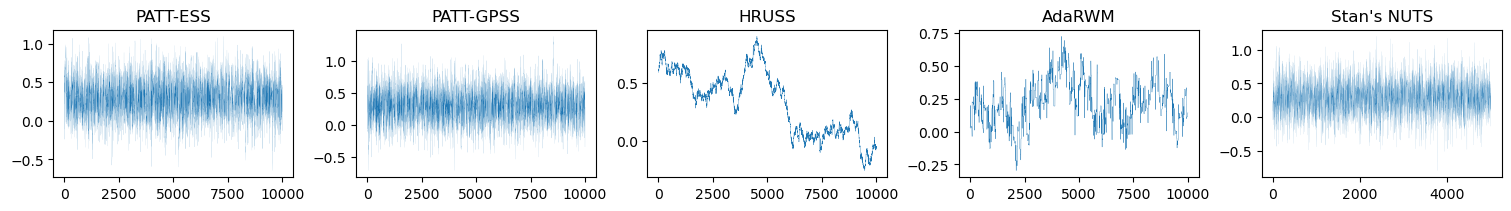

In [34]:
lws = [0.05, 0.05, 0.25, 0.25, 0.05]
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

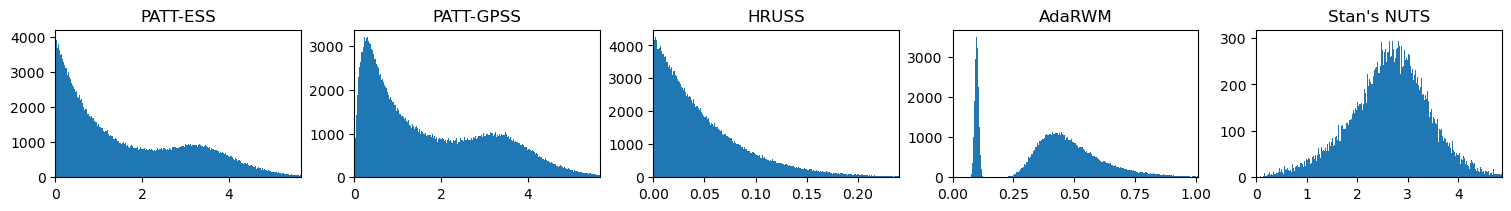

In [35]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[3] = plot_steps[3][plot_steps[3] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

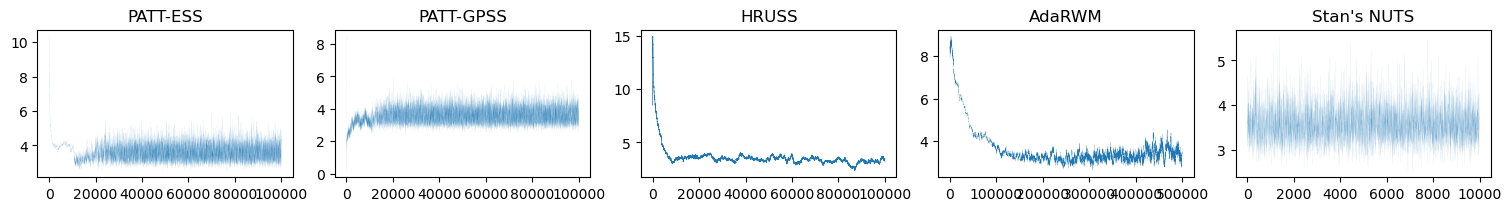

In [36]:
lws = [0.025, 0.025, 0.5, 0.1, 0.025]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

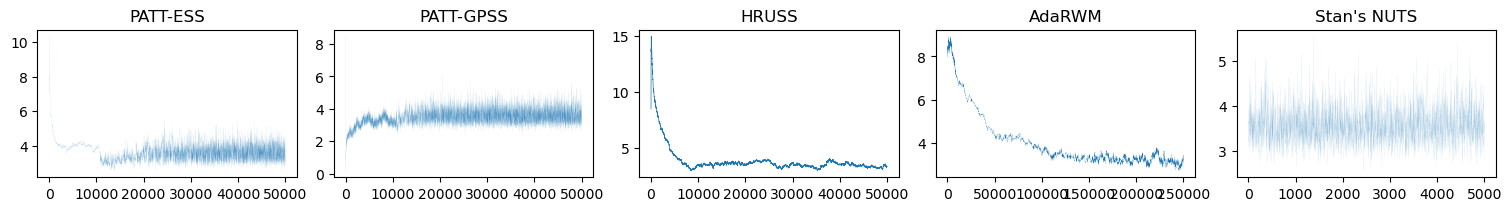

In [37]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

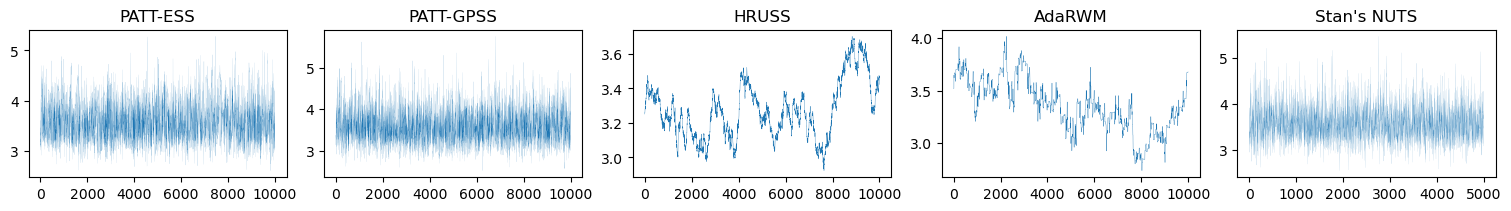

In [38]:
lws = [0.05, 0.05, 0.25, 0.25, 0.05]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

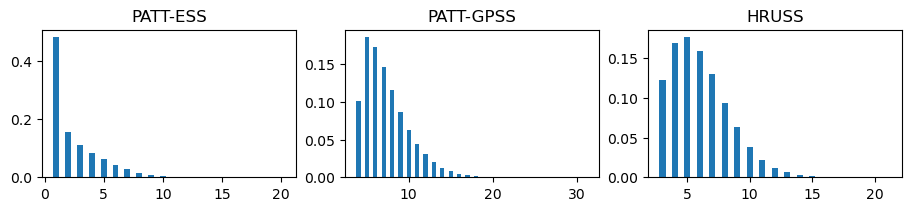

In [39]:
tde_inds = [0,1,2]
pfs.plot_tde_distr_row([tde[i] for i in tde_inds], [snames[i] for i in tde_inds])

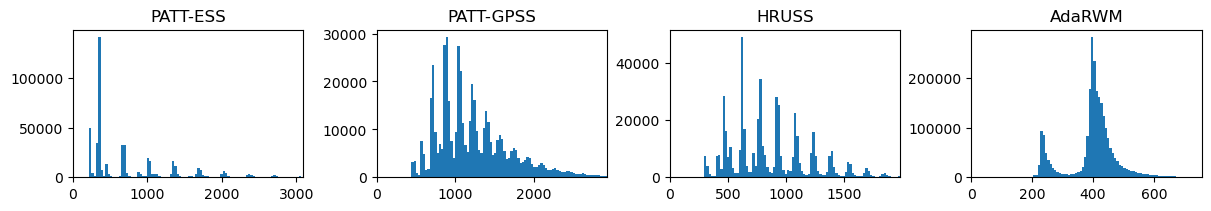

In [40]:
granular_times = [0,1,2,3]
pfs.plot_runtime_hist_row([times[i] for i in granular_times], 
                          [snames[i] for i in granular_times], nbins=100, cutoff_quant=0.99)

In [41]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.077
Minimal AdaRWM acceptance rate: 0.060
Maximal AdaRWM acceptance rate: 0.099


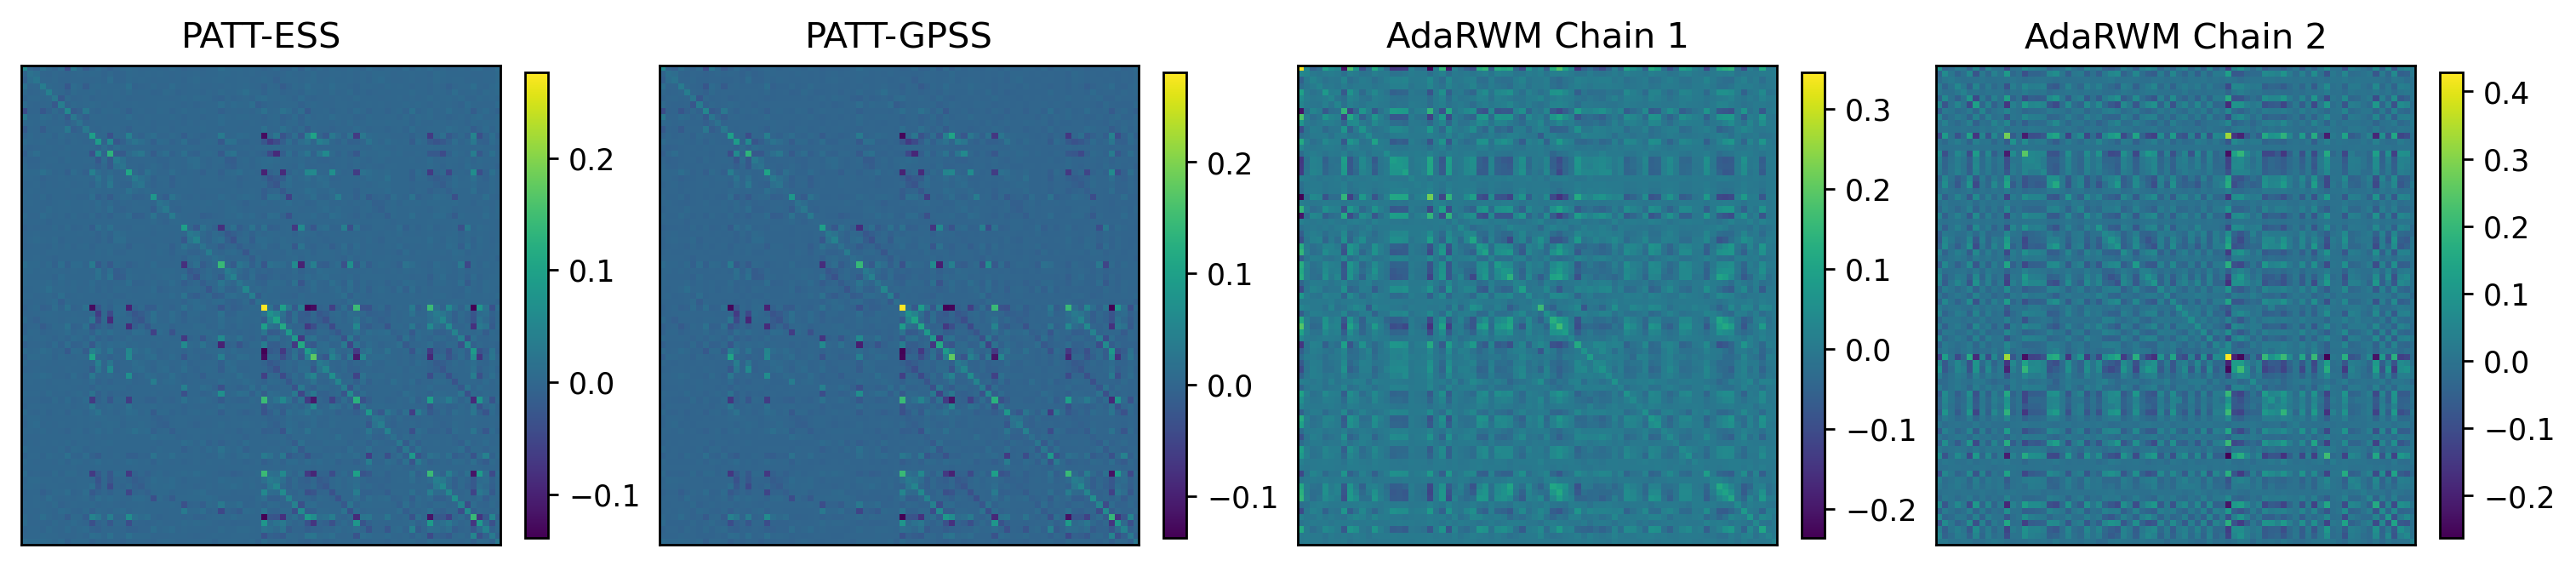

In [42]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "AdaRWM Chain 2"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], cov_rwm[1]]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path)

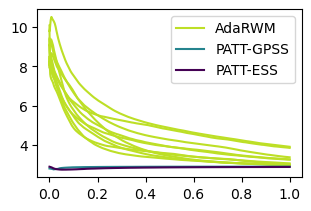

In [43]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
colors = plt.cm.viridis(np.linspace(0, 0.9, 3))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

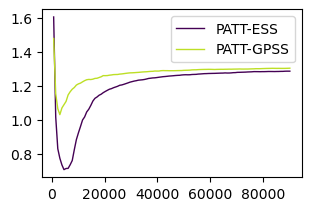

In [44]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

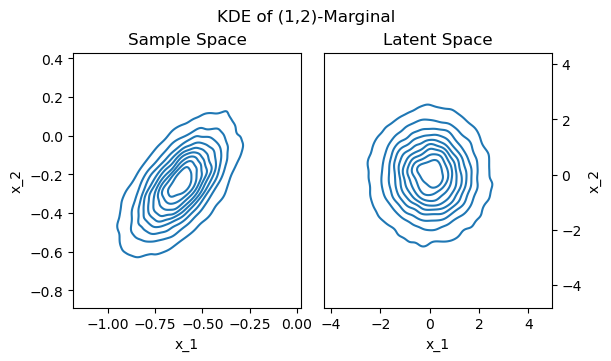

In [45]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [1,2]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

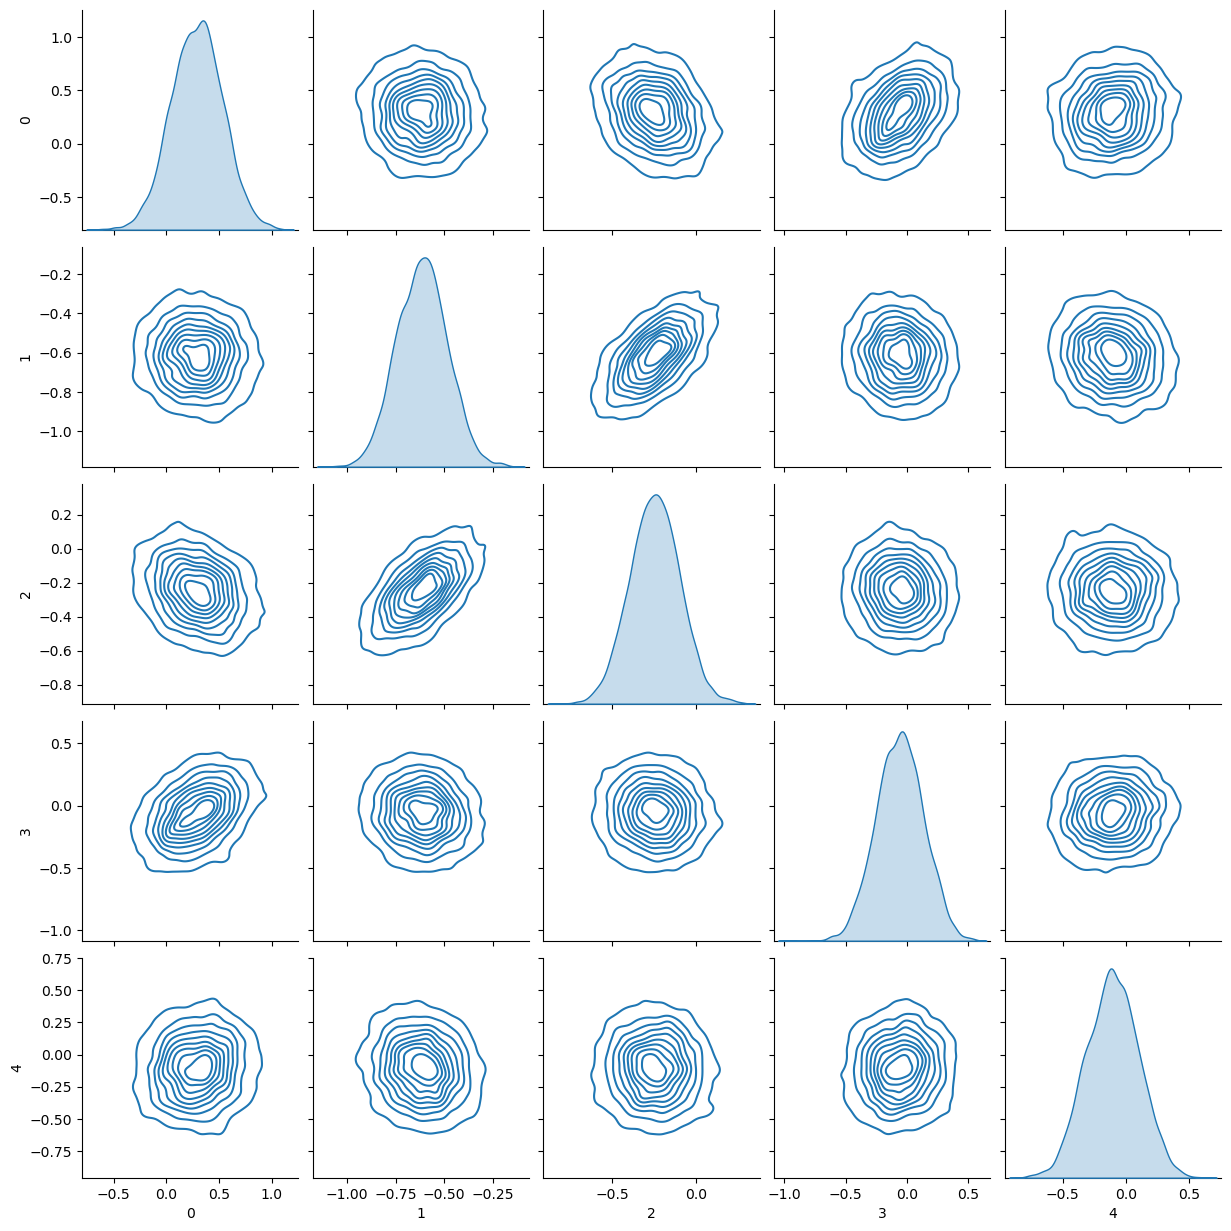

In [46]:
# this cell may take 1-2 min to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()

In [47]:
pos_mean_ests[0]

array([ 2.90122792e-01, -6.21764752e-01, -2.54221751e-01, -6.26323192e-02,
       -1.10452481e-01,  5.49522482e-01, -7.55290313e-01, -2.05868727e-01,
       -1.90743035e-01,  9.49389559e-01,  1.16733728e+00, -4.93098755e-01,
       -4.36372524e-01,  1.02369334e-01, -3.16536057e-01,  4.29440004e-01,
        1.92734764e-01, -3.53457002e-01, -1.62483713e-01, -1.03576590e-01,
       -2.41435890e-02, -6.64320183e-01,  1.57815518e-02,  5.77735325e-02,
        1.65600196e-01, -4.00108455e-02, -1.22532272e-01, -1.27253603e-01,
        1.25189369e-01,  2.05227632e-01, -9.64222325e-02, -1.81630775e-01,
        4.87509401e-02,  2.27082916e-01, -3.03462854e-02,  9.46101478e-02,
       -4.03902102e-01, -2.08681080e-01, -5.79922246e-02,  6.22475954e-01,
        1.57650171e-01, -7.38127044e-02,  1.59074344e-01,  7.38954958e-02,
        6.11489895e-03, -3.71126993e-01,  1.84632212e-02,  1.70804476e-03,
       -2.20210627e-01, -4.87638719e-01, -1.27535866e-01, -3.12075205e-01,
        1.07354539e-01, -